# Построение модели ARIMA для RTSI

В этой программе рассмотрим построение модели ARIMA для RTSI. Известны данные по индексу RTSI за 1998-2017 года, необходимо построить прогноз на следующие 3 года.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


Введем датасет(набор данных) состоящий из даты и значений акций, входящие в индекс

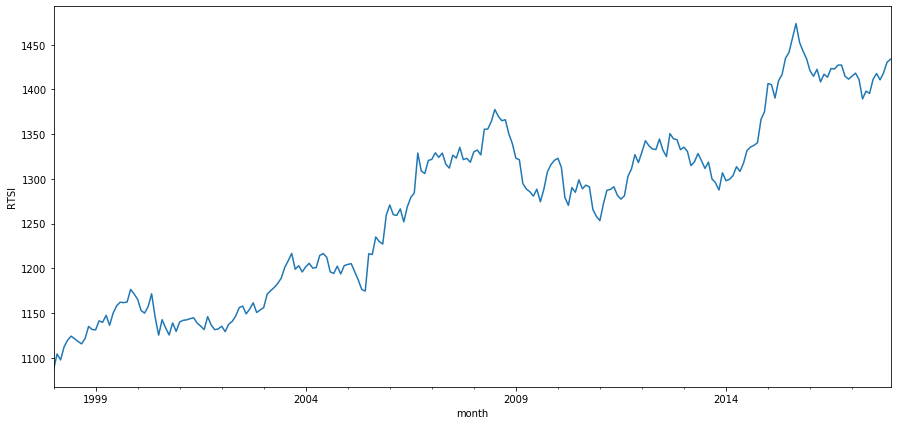

In [2]:
df = pd.read_csv('C:/Users/user/Desktop/ARIMA(RTSI)/VASYA4.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
df.id.plot()
plt.ylabel('RTSI')
pylab.show()

Здесь определим Критерий Дики-Фуллера, проверку стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.724523


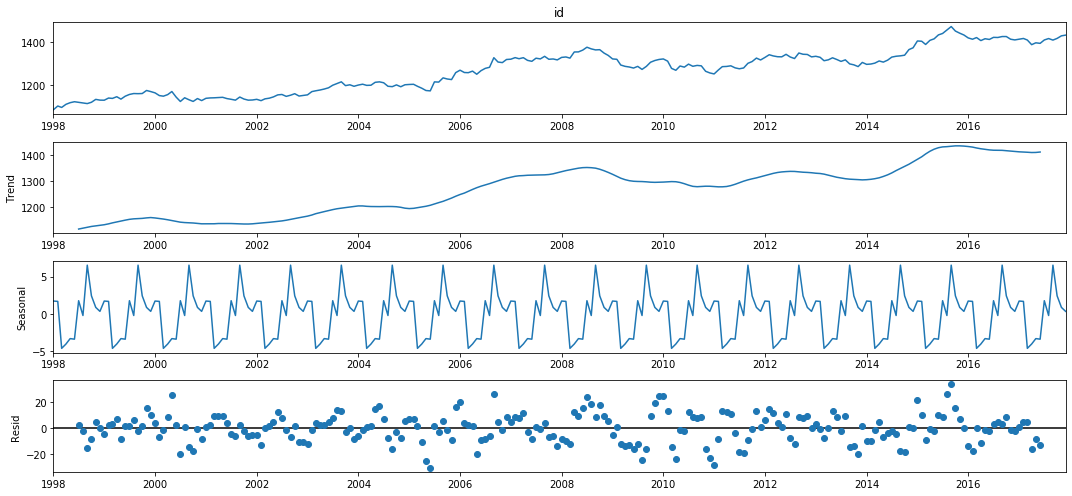

In [3]:
sm.tsa.seasonal_decompose(df.id,period=12).plot()
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.id)[1])

# Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии. Получим оптимальный параметр преобразования Бокса-Кокса:

Оптимальный параметр преобразования Бокса-Кокса: 0.742468
Критерий Дики-Фуллера: p=0.708323


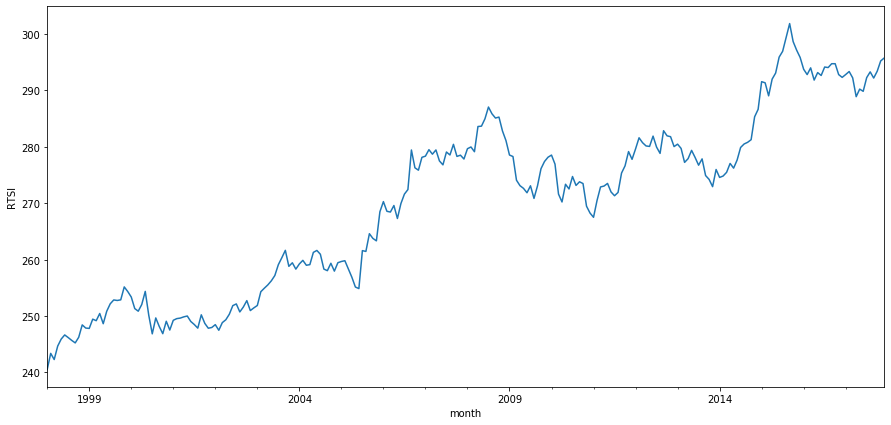

In [4]:
df['sales_box'], lmbda = stats.boxcox(pd.to_numeric(df.id))
plt.figure(figsize(15,7))
df.sales_box.plot()
plt.ylabel(u'RTSI')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.sales_box)[1])

# Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.027749


<Figure size 1080x720 with 0 Axes>

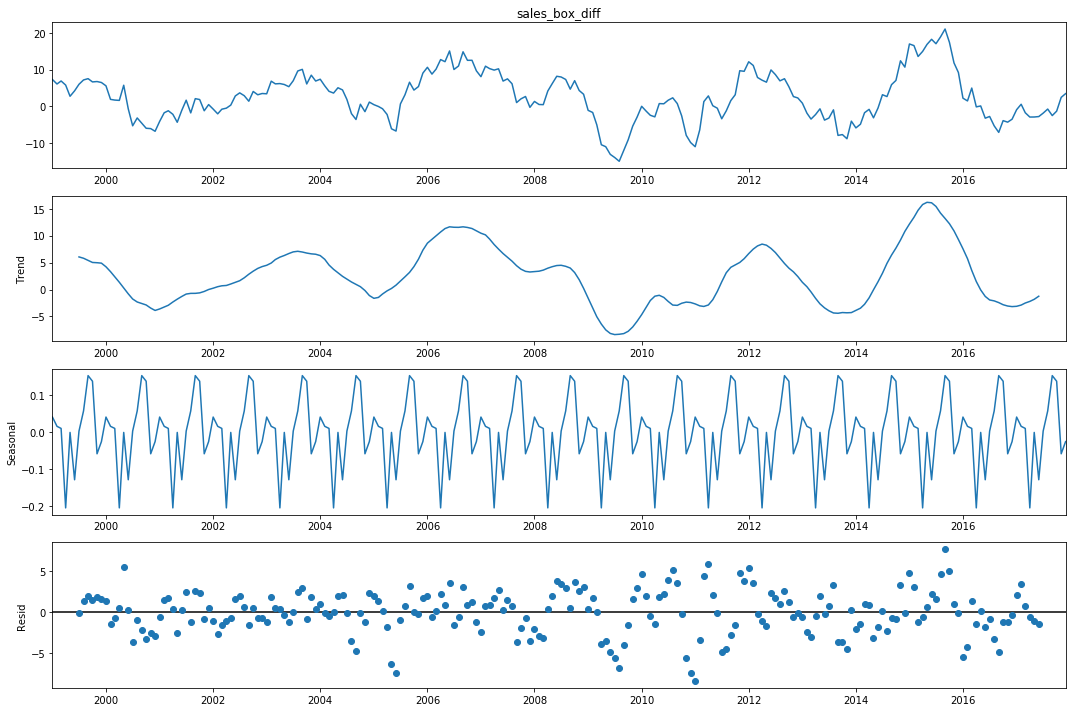

In [5]:
df['sales_box_diff'] = df.sales_box - df.sales_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.sales_box_diff[12:],period=12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.sales_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

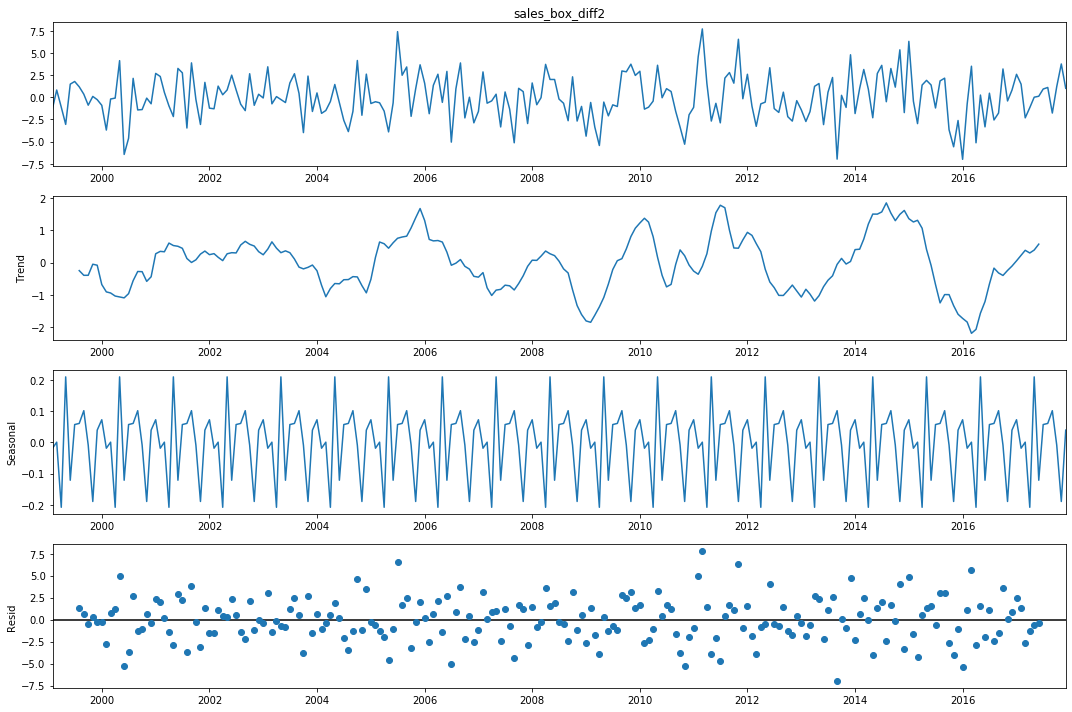

In [6]:
df['sales_box_diff2'] = df.sales_box_diff - df.sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.sales_box_diff2[13:],period=12).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.sales_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

# Подбор модели

Посмотрим на ACF и PACF полученного ряда:

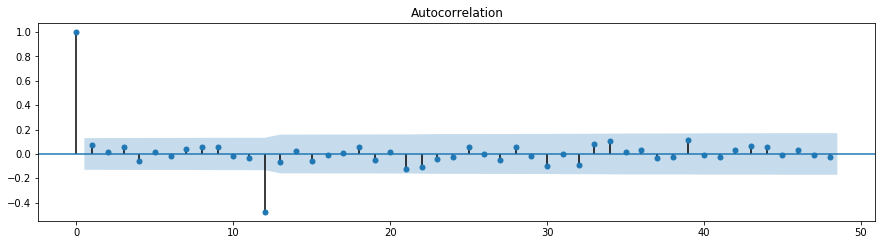

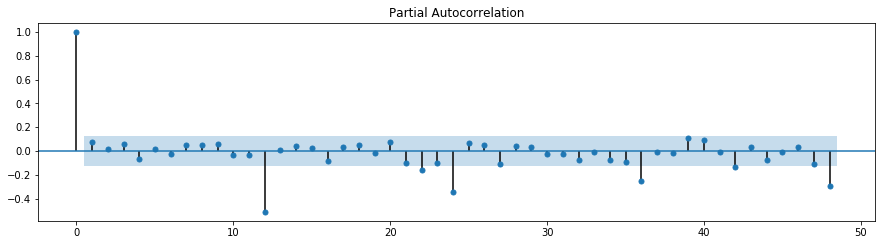

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=2, P=1, p=4

In [8]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [9]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

Выводим параметры, на которых модель не обучается и переходим к следующему набору:

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 1min 56s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1

In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
1   (0, 0, 0, 1)  949.343117
29  (2, 1, 0, 1)  950.437741
21  (1, 2, 0, 1)  950.454116
5   (0, 1, 0, 1)  951.326539
13  (1, 0, 0, 1)  951.326558


Получим лучшую модель:

In [12]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            sales_box   No. Observations:                  240
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -472.672
Date:                              Sat, 15 May 2021   AIC                            949.343
Time:                                      13:18:08   BIC                            956.193
Sample:                                  01-01-1998   HQIC                           952.107
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9991      6.636     -0.151      0.880     -14.005      12.007
sigma2         3.21

Её остатки:

Критерий Стьюдента: p=0.601698
Критерий Дики-Фуллера: p=0.000000


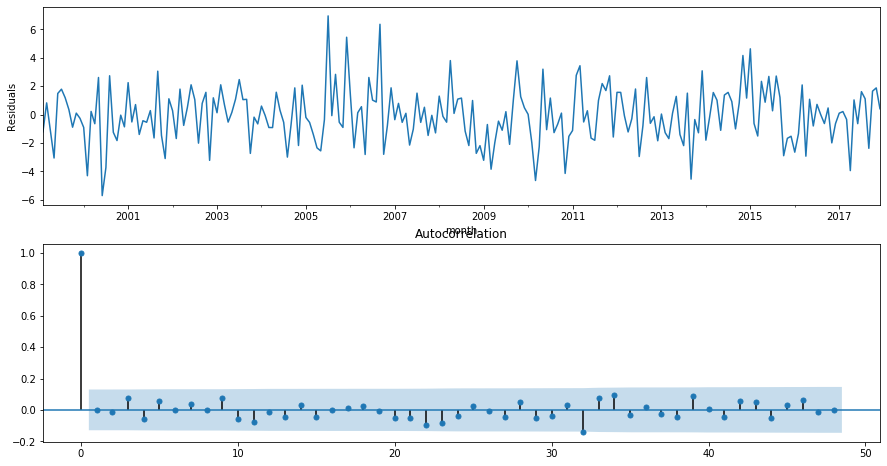

In [13]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

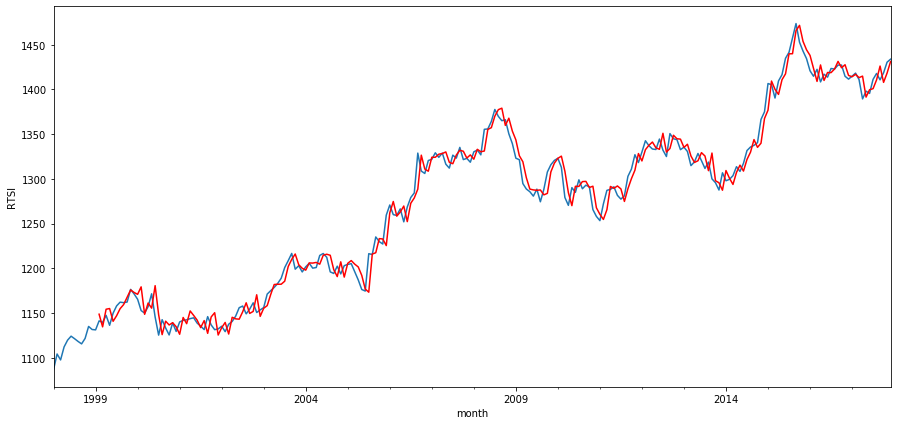

In [14]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.id.plot()
df.model[13:].plot(color='r')
plt.ylabel('RTSI')
pylab.show()

# Прогноз

Построим прогноз

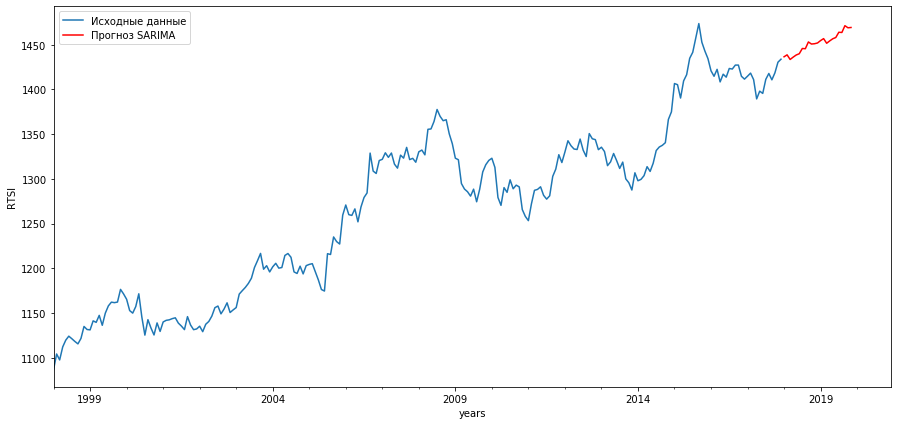

In [29]:
df2= df[['id']]
date_list = [datetime.datetime.strptime("2018-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=240, end=262), lmbda)

plt.figure(figsize(15,7))
df2.id.plot()
df2.forecast.plot(color='r')
plt.legend(['Исходные данные', 'Прогноз SARIMA' ],loc='upper left') 
plt.ylabel('RTSI')  
plt.xlabel('years')
pylab.show()

Добавим данные за 2018-2020 года, чтобы сравнить с прогнозом

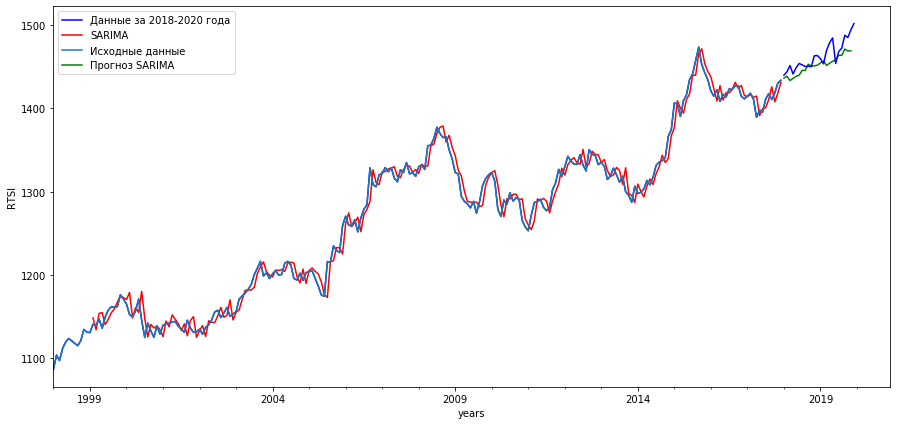

In [30]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)

df2= df[['id']]
date_list = [datetime.datetime.strptime("2018-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=240, end=262), lmbda)

df3 = pd.read_csv('C:/Users/user/Desktop/forecast/VASYA1.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
df.id.plot(color='blue')
df.model[13:].plot(color='red')
df2.id.plot()
df2.forecast.plot(color='green')
df3.id.plot(color='blue')
plt.legend(['Данные за 2018-2020 года',  'SARIMA', 'Исходные данные', 'Прогноз SARIMA' ],loc='upper left')
plt.ylabel('RTSI')
plt.xlabel('years')
pylab.show()

#plt.plot(x, y1, 'o-r')
#plt.plot(x, y2, 'o-.g')
#plt.legend(['L1', 'L2'])

In [31]:
from sklearn import tree
import seaborn as sns
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline 
from sklearn.metrics import mean_squared_error, r2_score
r2_score(df.id, df.model[:])
#r2_score(df2.forecast, df3.id)

0.21047683760590685

-0.48345997902230553

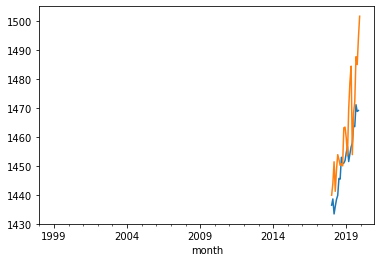

In [32]:
df2.forecast.plot()
df3.id.plot()
r2_score(df2.forecast[240:263],df3.id[:23])

In [33]:
from sklearn.model_selection import TimeSeriesSplit
#Specify fold and perform splitting
# Указать сгиб и выполнить разделение
tscv = TimeSeriesSplit(n_splits=4)
tscv.split(df)
#Find out no of observations in train and test sets
# Узнать количество наблюдений в тренировочных и тестовых наборах
i = 0
i=i+1
for train, test in tscv.split(df):
    
    print ("No of observations under train%s=%s" % (i, len(train)))
    print ("No of observations under test%s=%s" % (i, len(test)))

No of observations under train1=48
No of observations under test1=48
No of observations under train1=96
No of observations under test1=48
No of observations under train1=144
No of observations under test1=48
No of observations under train1=192
No of observations under test1=48


In [55]:
train1, test1 = df.iloc[0:60, 0], df.iloc[60:64, 0]
train2, test2 = df.iloc[64:120, 0], df.iloc[120:124, 0]
train3, test3 = df.iloc[124:180, 0], df.iloc[180:184, 0]
train4, test4 = df.iloc[184:230, 0], df.iloc[230:234, 0]

In [56]:
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

#df2['forecast'] = invboxcox(best_model.predict(start=240, end=262), lmbda)

model1=sm.tsa.statespace.SARIMAX(train1, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
pred1 = invboxcox(train1.predict(start=61, end=70), lmbda)
#model1.predict(start=test1.index[0], end=test1.index[-1])
r_squared1 = r2_score(test1, pred1)


model2=sm.tsa.statespace.SARIMAX(train2, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
pred2 = invboxcox(train2.predict(start=121, end=130), lmbda) 
#model2.predict(start=test2.index[0], end=test2.index[-1])
r_squared2 = r2_score(test2, pred2)


model3=sm.tsa.statespace.SARIMAX(train3, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
pred3 = invboxcox(train3.predict(start=181, end=190), lmbda)
r_squared3 = r2_score(test3, pred3)

#model3=sm.tsa.statespace.SARIMAX(train3, order=(param[0], 2, param[1]), 
                                            #seasonal_order=(param[2], 2, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
#pred3 = model3.predict(start=test3.index[0], end=test3.index[-1])
#r_squared3 = r2_score(test3, pred3)

model4=sm.tsa.statespace.SARIMAX(train4, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
pred4 = invboxcox(train4.predict(start=231, end=239), lmbda) 
#model4.predict(start=test4.index[0], end=test4.index[-1])
r_squared4 = r2_score(test4, pred4)

print("r_squared1: ", r_squared1)
print("r_squared2: ", r_squared2)
print("r_squared3: ", r_squared3)
print("r_squared4: ", r_squared4)



Overall_r_squared=round((r_squared1+r_squared2+r_squared3+r_squared4)/4,3)
print ("Overall r_squared:", Overall_r_squared)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: Co

AttributeError: 'Series' object has no attribute 'predict'

In [37]:
s_obj = SARIMA(Ps, Qs, ps, qs, d, D, self)#Ps, Qs, ps, qs)

#s_obj.fit(train1)
m_ind = len(train1)
y_pr1 = s_obj.predict(m_ind, m_ind + len(df_test1))

#s_obj.fit(train2)
m_ind = len(train2)
y_pr2 = s_obj.predict(m_ind, m_ind + len(df_test2))

#s_obj.fit(train3)
m_ind = len(train3)
y_pr3 = s_obj.predict(m_ind, m_ind + len(df_test3))	

v1 = r2_score(y_pr1, y_test1)
v2 = r2_score(y_pr2, y_test2)
v3 = r2_score(y_pr3, y_test3)

NameError: name 'self' is not defined

In [65]:
def f():
    %%time
    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')


    for param in parameters_list:
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(train, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        warnings.filterwarnings('default')

        return best_param, model 


class SARIMA():
    def __init__(self, Ps, Qs, ps, d, D):
        self.Qs = Qs
        self.ps = ps
        self.d = d
        self.D = D
        #self.qs = qs
        #self.Ps = Ps

    # close method
    def choose_SARIMA(self, train): # реализовать self
        from itertools import product
        parameters = product(self.ps, self.qs, self.Ps, self.Qs)
        parameters_list = list(parameters)
        len(parameters_list)
        
        # for param in parameters
        
        
        
        return #что нужно возвращать 

    def fit(self, train):
                      
        d1, lmbda = stats.boxcox(pd.to_numeric(train))
        best_param, best_model = self.choose_SARIMAX(d1)  
        self_best_model = best_model
        self_best_param = best_param
        self.model = invoboxcox(best_motel.fittedvalues, lmbda)

    def predict(start, end): # передавать сюда старт и энд
        return invboxcox(self_best_model.predict(start, end), lmbda)
    
f()
r2_sqared = r2_score(test,pred))

UsageError: Line magic function `%%time` not found.


In [70]:
r2_sqared = r2_score(test,train)

ValueError: Found input variables with inconsistent numbers of samples: [48, 192]

In [62]:
train

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [57]:
from sklearn.metrics import mean_squared_error, r2_score
model1=sm.tsa.statespace.SARIMAX(train1, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
pred1 = model1.predict(start=test1.index[0], end=test1.index[-1])
r_squared1 = r2_score(test1, pred1)

model2=sm.tsa.statespace.SARIMAX(train2, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
pred2 = model1.predict(start=test2.index[0], end=test2.index[-1])
r_squared2 = r2_score(test2, pred2)

model3=sm.tsa.statespace.SARIMAX(train3, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
pred3 = model3.predict(start=test3.index[0], end=test3.index[-1])
r_squared3 = r2_score(test3, pred3)


model4=sm.tsa.statespace.SARIMAX(train4, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
pred4 = model4.predict(start=test4.index[0], end=test4.index[-1])
r_squared4 = r2_score(test4, pred4)


print("r_squared1: ", r_squared1)
print("r_squared2: ", r_squared2)
print("r_squared3: ", r_squared3)
print("r_squared4: ", r_squared4)



Overall_r_squared=round((r_squared1+r_squared2+r_squared3+r_squared4)/4,3)
print ("Overall r_squared:", Overall_r_squared)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: Co

r_squared1:  -1.2055165787025914
r_squared2:  -74.391838688538
r_squared3:  -18.80085308982637
r_squared4:  -7.272481880811853
Overall r_squared: -25.418


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


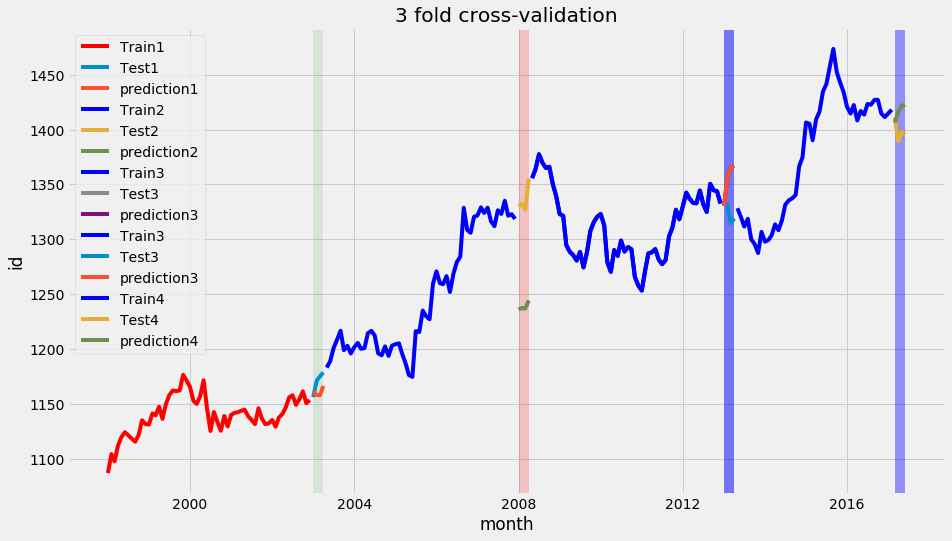

In [58]:
import matplotlib.pyplot as plt
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 14,8

#Labels and titles
plt.xlabel("month")
plt.ylabel("id")
plt.title("3 fold cross-validation")

#First fold- CV
plt.plot(train1.index, train1, label='Train1', color='red')
plt.plot(test1.index, test1, label='Test1') #, color='orange')
plt.plot(pred1.index, pred1, label='prediction1')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test1.index[0], test1.index[-1],  facecolor='green', alpha=0.1)

#Second fold
plt.plot(train2.index, train2, label='Train2', color='blue')
plt.plot(test2.index, test2, label='Test2')#, color='brown')
plt.plot(pred2.index, pred2, label='prediction2')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test2.index[0], test2.index[-1],  facecolor='red', alpha=0.2)

#Third fold
plt.plot(train3.index, train3, label='Train3', color='blue')
plt.plot(test3.index, test3, label='Test3')
plt.plot(pred3.index, pred3, label='prediction3')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test3.index[0], test3.index[-1],  facecolor='blue', alpha=0.3)

#Third fold
plt.plot(train3.index, train3, label='Train3', color='blue')
plt.plot(test3.index, test3, label='Test3')
plt.plot(pred3.index, pred3, label='prediction3')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test3.index[0], test3.index[-1],  facecolor='blue', alpha=0.3)

#Third fold
plt.plot(train4.index, train4, label='Train4', color='blue')
plt.plot(test4.index, test4, label='Test4')
plt.plot(pred4.index, pred4, label='prediction4')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test4.index[0], test4.index[-1],  facecolor='blue', alpha=0.4)

In [63]:
# y_true, y_pred
from sklearn.metrics import mean_squared_error, r2_score
model=sm.tsa.statespace.SARIMAX(train, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])
r_squared = r2_score(test, pred)
print(r_squared)

LinAlgError: Non-positive-definite forecast error covariance matrix encountered at period 18

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
model1=sm.tsa.statespace.SARIMAX(train3, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#model1 = SARIMAX(train1, seasonal='mul', seasonal_periods=12).fit()
pred3 = model1.predict(start=test3.index[0], end=test3.index[-1])
r_squared3 = r2_score(test3, pred3)
print(r_squared3)

In [ ]:
test1.shape()
train1.
test2.
train2.
test3.
train3.

In [75]:
train1.prop()

AttributeError: 'Series' object has no attribute 'prop'

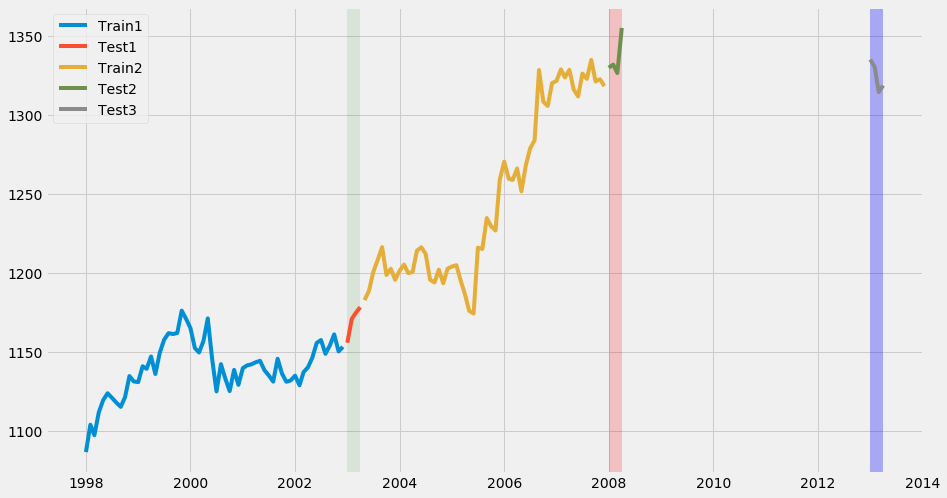

In [76]:
#First fold- CV
plt.plot(train1.index, train1, label='Train1')
plt.plot(test1.index, test1, label='Test1')
#plt.plot(pred1.index, pred1, label='prediction1')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test1.index[0], test1.index[-1],  facecolor='g', alpha=0.1)

#Second fold
plt.plot(train2.index, train2, label='Train2')
plt.plot(test2.index, test2, label='Test2')
#plt.plot(pred2.index, pred2, label='prediction2')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test2.index[0], test2.index[-1],  facecolor='r', alpha=0.2)

#Third fold
plt.plot(test3.index, test3, label='Test3')
#plt.plot(pred3.index, pred3, label='prediction3')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test3.index[0], test3.index[-1],  facecolor='b', alpha=0.3)

In [73]:
pred3

2013-01-01    1330.295002
2013-02-01    1356.124424
2013-03-01    1365.208674
2013-04-01    1366.909620
Freq: MS, dtype: float64

In [ ]:
#y_true1 = df.id
#y_pred1 = df2.forecast
#r2_score(y_true1, y_pred1)

In [ ]:
#df2.plot()
#df2.forecast.plot(color='r')

In [ ]:
#df2.id

In [ ]:
#df2.forecast

In [ ]:
#df.id.plot()

In [ ]:
#df2.forecast.plot()